<img src='https://institucional.ifood.com.br/images/share.jpg'>

 X   Column               Description
---  ------               --------------
 1   Year_Birth           Ano de nascimento
 2   Education            nível de educação dos clientes
 3   Marital_Status       estado civil dos clientes
 4   Income               renda familiar anual dos clientes
 5   Kidhome              número de crianças pequenas na casa do cliente
 6   Teenhome             número de adolescentes na casa do cliente
 7   Dt_Customer          data de inscrição do cliente na empresa
 8   Recency              número de dias desde a última compra
 9   MntWines             valor gasto em vinhos nos últimos 2 anos
 10  MntFruits            valor gasto em frutas nos últimos 2 anos
 11  MntMeatProducts      valor gasto com carnes nos últimos 2 anos
 12  MntFishProducts      valor gasto em produtos pesqueiros nos últimos 2 anos
 13  MntSweetProducts     valor gasto em produtos doces nos últimos 2 anos
 14  MntGoldProds         valor gasto em produtos ouro nos últimos 2 anos
 15  NumDealsPurchases    número de compras feitas com desconto
 16  NumWebPurchases      número de compras feitas através do site da empresa
 17  NumCatalogPurchases  número de compras feitas usando catalogo
 18  NumStorePurchases    número de compras feitas diretamente nas lojas
 19  NumWebVisitsMonth    número de visitas ao site da empresa no último mês
 20  AcceptedCmp3         1 se o cliente aceitou a oferta na 3ª campanha, 0 caso contrário
 21  AcceptedCmp4         1 se o cliente aceitou a oferta na 4ª campanha, 0 caso contrário
 22  AcceptedCmp5         1 se o cliente aceitou a oferta na 5ª campanha, 0 caso contrário
 23  AcceptedCmp1         1 se o cliente aceitou a oferta na 1ª campanha, 0 caso contrário
 24  AcceptedCmp2         1 se o cliente aceitou a oferta na 2ª campanha, 0 caso contrário
 25  Complain             1 se o cliente reclamou nos últimos 2 anos
 28  Response             1 se o cliente aceitou a oferta na última campanha, 0 caso contrário

In [54]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import isneginf
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn import metrics

from sklearn.decomposition import PCA

In [118]:
df = pd.read_csv('ml_project1_data.csv')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [119]:
# Actually we can drop "ID", "Z_CostContact" and "Z_Revenue" columns because we will not use it.
df = df.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'])
# Drop duplicates
df = df.drop_duplicates()

df.loc[df['Income'] == 666666.0, 'Income'] = np.nan
df = df.reset_index(drop=True)

In [120]:
# Lets check the missing values and fill them with appropriate method.
def null_values(df):
    nv=pd.DataFrame(df.isnull().sum()).rename(columns={0:'Missing_Records'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)
null_values(df)

,Missing_Records
Income,25


In [121]:
# We can fill the null values with mean.
df['Income'] = df['Income'].fillna(float(round(df['Income'].mean())))
null_values(df).sum()

Missing_Records    0.0
dtype: float64

In [122]:
# There are lots of outliers in columns but we will not apply winsorize or another methods to them.
# Because we may have information loss.
# They may represent another clusters.
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
((df[df.columns ]< (Q1 - 1.5 * IQR)) | (df[df.columns] > (Q3 + 1.5 * IQR))).sum()

AcceptedCmp1           135
AcceptedCmp2            26
AcceptedCmp3           151
AcceptedCmp4           158
AcceptedCmp5           148
Complain                20
Dt_Customer              0
Education                0
Income                   7
Kidhome                  0
Marital_Status           0
MntFishProducts        203
MntFruits              207
MntGoldProds           187
MntMeatProducts        174
MntSweetProducts       225
MntWines                33
NumCatalogPurchases     22
NumDealsPurchases       78
NumStorePurchases        0
NumWebPurchases          4
NumWebVisitsMonth        8
Recency                  0
Response               313
Teenhome                 0
Year_Birth               3
dtype: int64

In [123]:
df['Dt_Customer_Year'] = df['Dt_Customer'].str.split('-').str[0].astype('int64')
df['Dt_Customer_Month'] = df['Dt_Customer'].str.split('-').str[1].astype('int64')

df = df.drop(columns=['Dt_Customer'])

In [124]:
def birth(year):
    year_min = year - year%10
    year_max = year_min + 10
    
    return f'{year_min} - {year_max}'

In [125]:
def generation(year):
    if year <= 1964:
        gen = 'Boomers (year < 1964)'
    elif year >= 1965 and year <= 1980:
        gen = 'Gen X (1965 < year < 1980)'
    elif year >= 1981 and year <= 1996:
        gen = 'Gen Y (1981 < year < 1996)'
    elif year >= 1997 and year <= 2010:
        gen = 'Gen Z (1997 < year < 2010)'
    else:
        gen = 'Gen A (year > 2010)'
    return gen

In [126]:
def income(income_value):
    income_min = income_value - income_value%10000
    income_max = income_min + 10000
    
    return f'{income_min} - {income_max}'

In [127]:
def mnt_products(total):
    total_min = total - total%100
    total_max = total_min + 100
    
    return f'{total_min} - {total_max}'

In [128]:
df['Year_Birth_range'] = df['Year_Birth'].apply(lambda x: birth(x))
df['Age'] = df['Dt_Customer_Year'] - df['Year_Birth']
df['Generation'] = df['Year_Birth'].apply(lambda x: generation(x))
df['Income_range'] = df['Income'].apply(lambda x: income(x))
df['Recency_range'] = df['Recency'].apply(lambda x: birth(x))

df['MntProducts_total'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['MntProducts_total_range'] = df['MntProducts_total'].apply(lambda x: mnt_products(x))
df['NumPurchases_total'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']


# Customer Segmentation

### Find Your Best Customers - RFM table

RFM stands for Recency, Frequency, and Monetary. It is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

In [1472]:
segmented_rfm = df[['Recency', 'NumPurchases_total', 'MntProducts_total']]

In [1473]:
quantiles = segmented_rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [1474]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [1475]:
segmented_rfm['r_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['NumPurchases_total'].apply(FMScore, args=('NumPurchases_total',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['MntProducts_total'].apply(FMScore, args=('MntProducts_total',quantiles,))
segmented_rfm.head()

,Recency,NumPurchases_total,MntProducts_total,r_quartile,f_quartile,m_quartile
0,58,22,1617,3,1,1
1,38,4,27,2,4,4
2,26,20,776,2,1,2
3,26,6,53,2,4,4
4,94,14,422,4,2,2


In [1476]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,Recency,NumPurchases_total,MntProducts_total,r_quartile,f_quartile,m_quartile,RFMScore
0,58,22,1617,3,1,1,311
1,38,4,27,2,4,4,244
2,26,20,776,2,1,2,212
3,26,6,53,2,4,4,244
4,94,14,422,4,2,2,422


In [1478]:
# Calculate RFM_Score
segmented_rfm['RFMScore_sum'] = segmented_rfm[['r_quartile','f_quartile','m_quartile']].sum(axis=1)

In [1481]:
# Create human friendly RFM labels
segt_map = {
    r'[3-4][3-4]': 'Hibernating',
    r'[3-4][2-3]': 'At risk',
    r'[3-4]1': 'Can\'t loose them',
    r'3[3-4]': 'About to sleep',
    r'33': 'Need attention',
    r'[2-3][1-2]': 'Loyal customers',
    r'24': 'Promising',
    r'14': 'New customers',
    r'[1-2][3-4]': 'Potential loyalists',
    r'1[1-2]': 'Champions'
}

segmented_rfm['Segment'] = segmented_rfm['r_quartile'].map(str) + segmented_rfm['f_quartile'].map(str)
segmented_rfm['Segment'] = segmented_rfm['Segment'].replace(segt_map, regex=True)

# Create some human friendly labels for the scores
segmented_rfm.loc[segmented_rfm['RFMScore_sum']>2,'Score'] = 'Platinum'
segmented_rfm.loc[segmented_rfm['RFMScore_sum']>4,'Score'] = 'Gold'
segmented_rfm.loc[segmented_rfm['RFMScore_sum']>5,'Score'] = 'Silver'
segmented_rfm.loc[segmented_rfm['RFMScore_sum']>7,'Score'] = 'Bronze'
segmented_rfm.loc[segmented_rfm['RFMScore_sum']>9,'Score'] = 'Green'

In [1482]:
# best customers - score 111
segmented_rfm[segmented_rfm['RFMScore'].str.contains('111')].sort_values('MntProducts_total', ascending=False).head(10)


,Recency,NumPurchases_total,MntProducts_total,r_quartile,f_quartile,m_quartile,RFMScore,RFMScore_sum,Segment,Score
1458,16,25,2349,1,1,1,111,3,Champions,Platinum
490,11,19,2092,1,1,1,111,3,Champions,Platinum
1953,2,22,2092,1,1,1,111,3,Champions,Platinum
1672,20,21,2091,1,1,1,111,3,Champions,Platinum
1084,16,19,2087,1,1,1,111,3,Champions,Platinum
1113,23,19,2008,1,1,1,111,3,Champions,Platinum
650,23,19,2008,1,1,1,111,3,Champions,Platinum
917,9,19,1919,1,1,1,111,3,Champions,Platinum
543,9,19,1919,1,1,1,111,3,Champions,Platinum
519,19,19,1902,1,1,1,111,3,Champions,Platinum


Top 10 of the best consumers

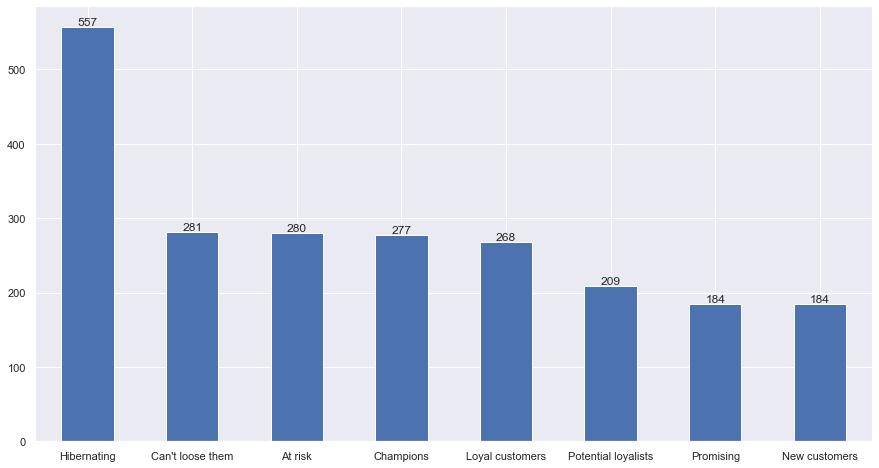

In [1486]:
ax = segmented_rfm['Segment'].value_counts().plot.bar(rot=0)

for container in ax.containers:
    ax.bar_label(container)

Behavior-based consumer classification

We have champions, New customers, Loyal customers, At risk, Hibernating

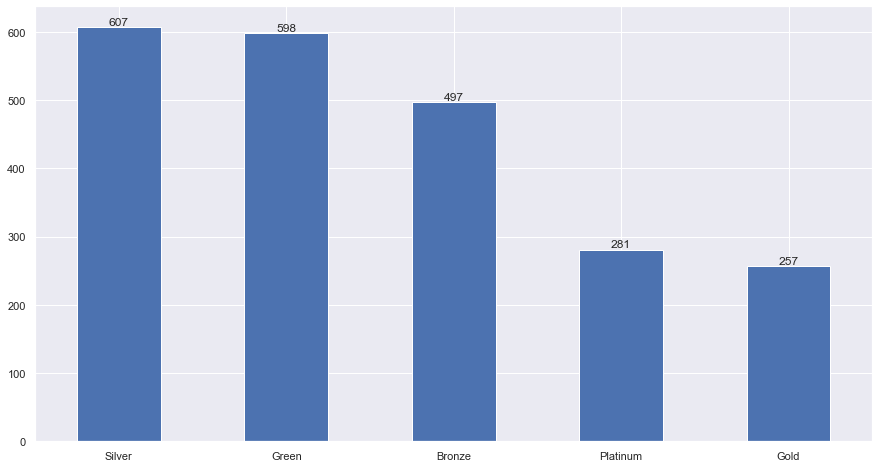

In [1487]:
ax = segmented_rfm['Score'].value_counts().plot.bar(rot=0)

for container in ax.containers:
    ax.bar_label(container)

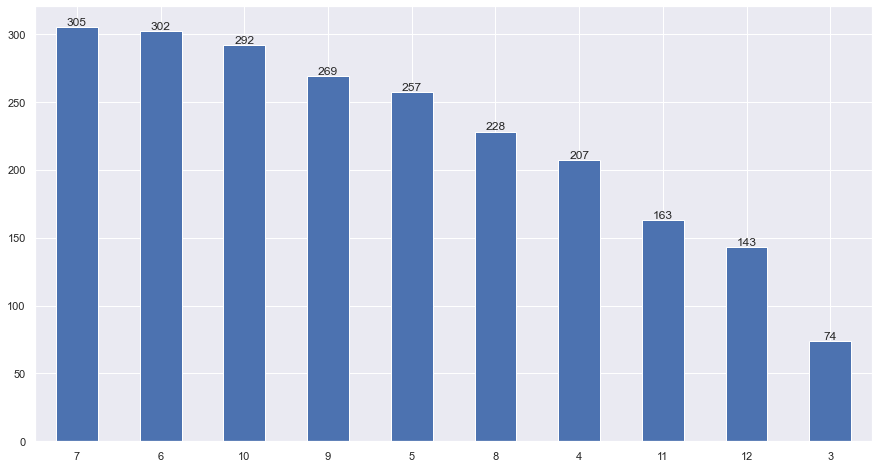

In [1488]:
ax = segmented_rfm['RFMScore_sum'].value_counts().plot.bar(rot=0)

for container in ax.containers:
    ax.bar_label(container)

### References

https://datascienceplus.com/find-your-best-customers-with-customer-segmentation-in-python/

# Create RFM Table

In [129]:
customers = df[['Income', 'Recency', 'NumPurchases_total', 'MntProducts_total']]
customers = customers.replace(0, 0.00000000001)

### Manage Skewness

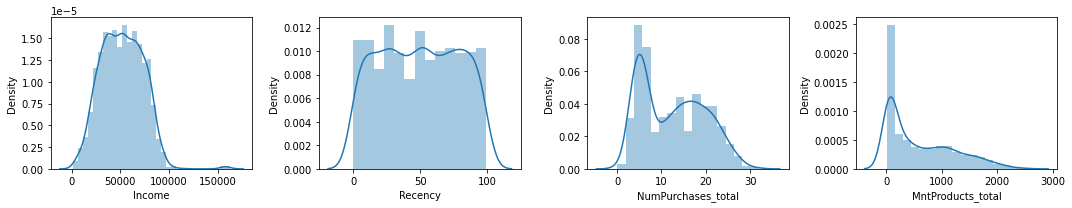

In [130]:
fig, ax = plt.subplots(1, 4, figsize=(15,3))
sns.distplot(customers['Income'], ax=ax[0])
sns.distplot(customers['Recency'], ax=ax[1])
sns.distplot(customers['NumPurchases_total'], ax=ax[2])
sns.distplot(customers['MntProducts_total'], ax=ax[3])
plt.tight_layout()
plt.show()

In [131]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(customers[x], ax=ax[0,0])
    sns.distplot(np.log(customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

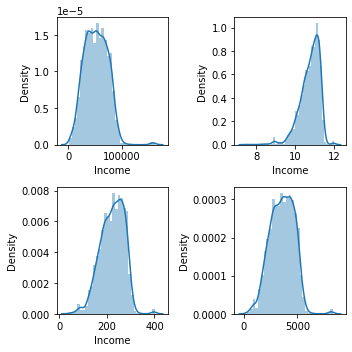

0.37
-1.31
-0.34
-0.02


In [132]:
# boxcox
analyze_skewness('Income')

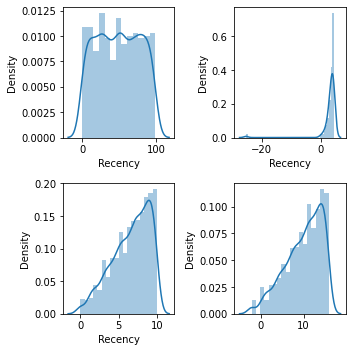

0.0
-7.73
-0.63
-0.71


In [133]:
# customers['Recency']
analyze_skewness('Recency')

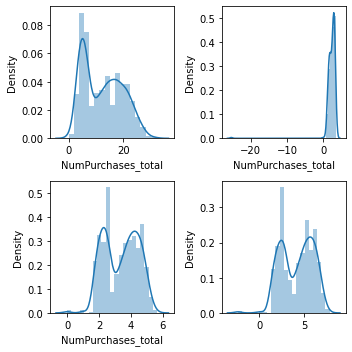

0.3
-13.96
-0.1
-0.21


In [134]:
# sqrt
analyze_skewness('NumPurchases_total')

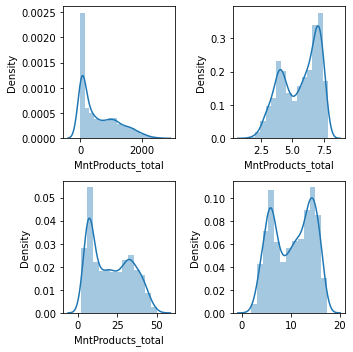

0.87
-0.4
0.29
-0.12


In [135]:
# boxcox
analyze_skewness('MntProducts_total')

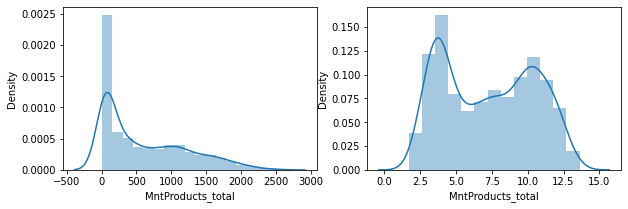

0.87
0.08


In [136]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(customers['MntProducts_total'], ax=ax[0])
sns.distplot(np.cbrt(customers['MntProducts_total']), ax=ax[1])
plt.show()
print(customers['MntProducts_total'].skew().round(2))
print(np.cbrt(customers['MntProducts_total']).skew().round(2))

In [137]:
# Set the Numbers
customers_fix = pd.DataFrame()
customers_fix["Income"] = stats.boxcox(customers['Income'])[0]
customers_fix["Recency"] = customers['Recency']
customers_fix["Frequency"] = np.sqrt(customers['NumPurchases_total'])
customers_fix["MonetaryValue"] = stats.boxcox(customers['MntProducts_total'])[0]
customers_fix.tail()

,Income,Recency,Frequency,MonetaryValue
2053,3640.609045,23.0,2.645751,6.157007
2054,4095.456332,46.0,4.000000,14.910709
2055,3887.485342,91.0,4.242641,14.624412
2056,4478.291205,8.0,4.582576,13.254784
2057,3681.789920,40.0,2.828427,8.538357


### Centering and Scaling Variables

In [138]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[-0. -0. -0. -0.]
[1. 1. 1. 1.]


### Modelling
Choose k-number

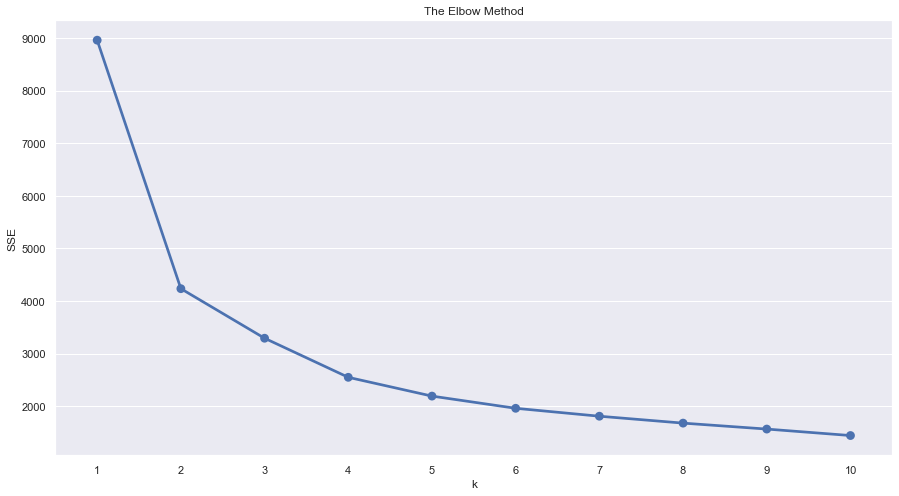

In [1275]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [1276]:
for i in range(2,11):
    kmeans_labels=KMeans(n_clusters=i,random_state=123).fit_predict(customers_normalized)
    print("Silhouette score for {} clusters k-means : {} ".format(i,metrics.silhouette_score(customers_normalized,kmeans_labels, metric='euclidean').round(3)))
    

Silhouette score for 2 clusters k-means : 0.456 
Silhouette score for 3 clusters k-means : 0.378 
Silhouette score for 4 clusters k-means : 0.34 
Silhouette score for 5 clusters k-means : 0.339 
Silhouette score for 6 clusters k-means : 0.319 
Silhouette score for 7 clusters k-means : 0.298 
Silhouette score for 8 clusters k-means : 0.273 
Silhouette score for 9 clusters k-means : 0.27 
Silhouette score for 10 clusters k-means : 0.271 


In [1277]:
for i in range(2,11):
    kmeans_labels=KMeans(n_clusters=i,random_state=123).fit_predict(customers_normalized)
    print(str(i)+'Davies Bouldin Score:'+str(metrics.davies_bouldin_score(customers_normalized,kmeans_labels).round(3)))

2Davies Bouldin Score:0.872
3Davies Bouldin Score:1.001
4Davies Bouldin Score:1.112
5Davies Bouldin Score:1.004
6Davies Bouldin Score:1.016
7Davies Bouldin Score:1.099
8Davies Bouldin Score:1.17
9Davies Bouldin Score:1.173
10Davies Bouldin Score:1.064


In [1278]:
kmeans_labels=KMeans(n_clusters=4,random_state=123).fit_predict(customers_normalized)

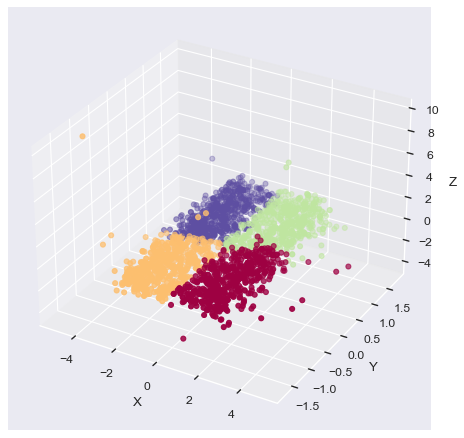

In [1279]:
pca = PCA(n_components=3).fit_transform(customers_normalized)
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=kmeans_labels,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

In [1280]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2240,)

### Cluster Analysis

In [1281]:
customers["Cluster"] = model.labels_
customers.head()

,Income,Recency,NumPurchases_total,MntProducts_total,Cluster
0,58138.0,58.0,22.0,1617,0
1,46344.0,38.0,4.0,27,3
2,71613.0,26.0,20.0,776,2
3,26646.0,26.0,6.0,53,3
4,58293.0,94.0,14.0,422,0


In [1282]:
customers.groupby('Cluster').agg({
    'Income':'mean',
    'Recency':'mean',
    'NumPurchases_total':'mean',
    'MntProducts_total':['mean', 'count']}).round(1)

Income Recency NumPurchases_total MntProducts_total      
            mean    mean               mean              mean count
Cluster                                                            
0        67732.5    72.5               18.6            1090.7   618
1        36425.8    74.8                6.3             116.6   523
2        67897.6    22.5               18.1            1000.2   579
3        32330.3    25.1                5.5              82.4   520

### Snake Plots

In [1289]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Income', 'Recency', 'Frequency', 'MonetaryValue'])
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Income,Recency,Frequency,MonetaryValue,Cluster
0,0.365968,0.307039,1.228668,1.314870,0
1,-0.140537,-0.383664,-1.284414,-1.442456,3
2,0.881184,-0.798086,1.024776,0.660573,2
3,-1.174271,-0.798086,-0.864551,-1.115271,3
4,0.372239,1.550305,0.342445,0.179460,0


In [1284]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['Cluster'],
                      value_vars=['Income', 'Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,Cluster,Attribute,Value
0,0,Income,0.365968
1,3,Income,-0.140537
2,2,Income,0.881184
3,3,Income,-1.174271
4,0,Income,0.372239


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

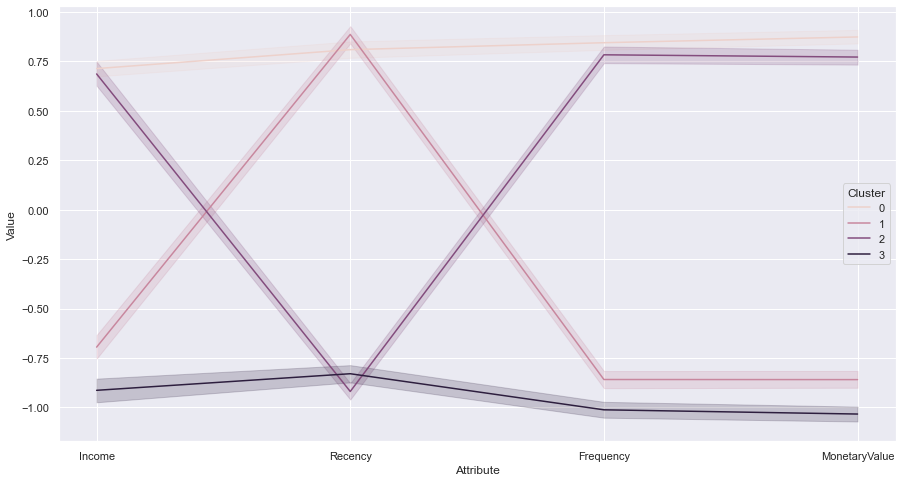

In [1285]:
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

#### Cluster 0: High income, frequent customers, spend more and take longer to buy products. So it might be the cluster of recurring customers who spend the most at important times.

#### Cluster 1: Low income, less frequent customers, spend less and take longer to buy products. So it might be the cluster of churned customers.

#### Cluster 2: High income, frequent customers, spend more and purchased products recently. So it might be the cluster of loyal customers.

#### Cluster 3: Low income, less frequent customers, spend less and have recently purchased products. So it might be the cluster of new customers.

In [1286]:
customers.groupby('Cluster').agg({
    'Income':'mean',
    'Recency':'mean',
    'NumPurchases_total':'mean',
    'MntProducts_total':['mean', 'count']}).round(1)

Income Recency NumPurchases_total MntProducts_total      
            mean    mean               mean              mean count
Cluster                                                            
0        67732.5    72.5               18.6            1090.7   618
1        36425.8    74.8                6.3             116.6   523
2        67897.6    22.5               18.1            1000.2   579
3        32330.3    25.1                5.5              82.4   520

In [1287]:
cluster_avg = customers.groupby('Cluster').mean()
population_avg = customers.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp

,Cluster,Income,MntProducts_total,NumPurchases_total,Recency
Cluster,,,,,
0,NaN,0.296384,0.800510,0.480401,0.477186
1,NaN,-0.302819,-0.807501,-0.496407,0.522570
2,NaN,0.299544,0.650986,0.440841,-0.542068
3,NaN,-0.381206,-0.864064,-0.562528,-0.489131


### References
Daqing C., Sai L.S, and Kun G., Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining (2012), Journal of Database Marketing and Customer Strategy Management.<br>
K. Jarrod Millman and Michael Aivazis. Python for Scientists and Engineers(2011). Computing in Science & Engineering.<br>
https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45<br>
https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

https://towardsdatascience.com/customer-segmentation-in-python-9c15acf6f945

### Cluster / Response Validation

In [1294]:
df['Cluster'] = model.labels_

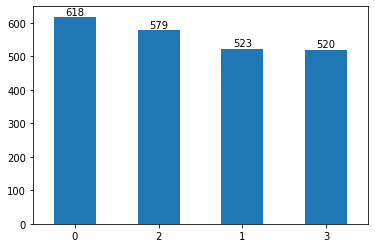

In [49]:
# Total clusters
ax = df['Cluster'].value_counts().plot.bar(rot=0)

for container in ax.containers:
    ax.bar_label(container)

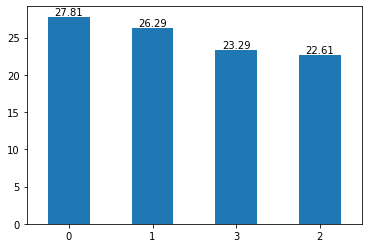

In [13]:
# Response 0
ax = round(df[df['Response']==0]['Cluster'].value_counts() / df[df['Response']==0].shape[0] * 100, 2).plot.bar(rot=0)

for container in ax.containers:
    ax.bar_label(container)

#### Cluster 0 is the one that refuses the most offers - customers of important times - 27.81%

#### Cluster 1 also refuses - churned customers

#### Cluster 3 also refuses - new customers

## Cluster 2 is the least refuses - loyal customers - 22.61%

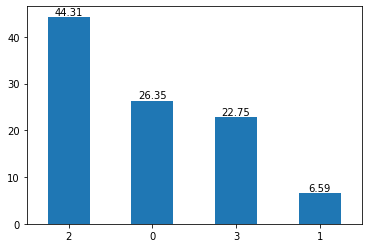

In [15]:
# Response 1
ax = round(df[df['Response']==1]['Cluster'].value_counts() / df[df['Response']==1].shape[0] * 100, 2).plot.bar(rot=0)

for container in ax.containers:
    ax.bar_label(container)

## Cluster 2 accepts a larger amount of offers - loyal customers - 44.31%

#### Cluster 0 also accepts - customers of important times

#### Cluster 3 also accepts - new customers

#### Cluster 1 is the least accepts - churned customers - 6.59%

In [ ]:
df['RFMScore'] = segmented_rfm['RFMScore']
df['RFMScore_sum'] = segmented_rfm['RFMScore_sum']
df['Segment'] = segmented_rfm['Segment']
df['Score'] = segmented_rfm['Score']

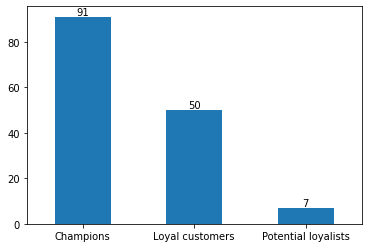

In [34]:
# Response 1 - Cluster 2 - Segment
ax = df[(df['Response']==1) & (df['Cluster']==2)]['Segment'].value_counts().plot.bar(rot=0)

for container in ax.containers:
    ax.bar_label(container)

In [1344]:
df.to_csv('customer_segmentation.csv', index=False)

# Customer Segmentation tests

### Gower Distance for categorical variables

In [1288]:
import gower

In [739]:
df_customers = df[['Education', 'Marital_Status', 'Income', 'Kidhome',
                   'Teenhome', 'Recency', 'NumDealsPurchases', 'NumWebVisitsMonth',
                   'Age', 'Generation', 'MntProducts_total', 'NumPurchases_total']]

In [710]:
distance_matrix = gower.gower_matrix(df_customers)

In [722]:
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.3, 
                        min_samples=2, 
                        metric="precomputed")

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
df_customers["cluster"] = dbscan_cluster.labels_

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [723]:
# Unsuccessful use of gower distance - dimensionality problem
df_customers['cluster'].value_counts()

0    2240
Name: cluster, dtype: int64

### Manage Skewness - analysis of variables

In [740]:
df_customers = pd.get_dummies(df_customers)
df_customers = df_customers.replace(0, 0.00000000001)

In [748]:
df_customers.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
       'NumWebVisitsMonth', 'Age', 'MntProducts_total', 'NumPurchases_total',
       'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Marital_Status_Absurd',
       'Marital_Status_Alone', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow',
       'Marital_Status_YOLO', 'Generation_Boomers (year < 1964)',
       'Generation_Gen X (1965 < year < 1980)',
       'Generation_Gen Y (1981 < year < 1996)'],
      dtype='object')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

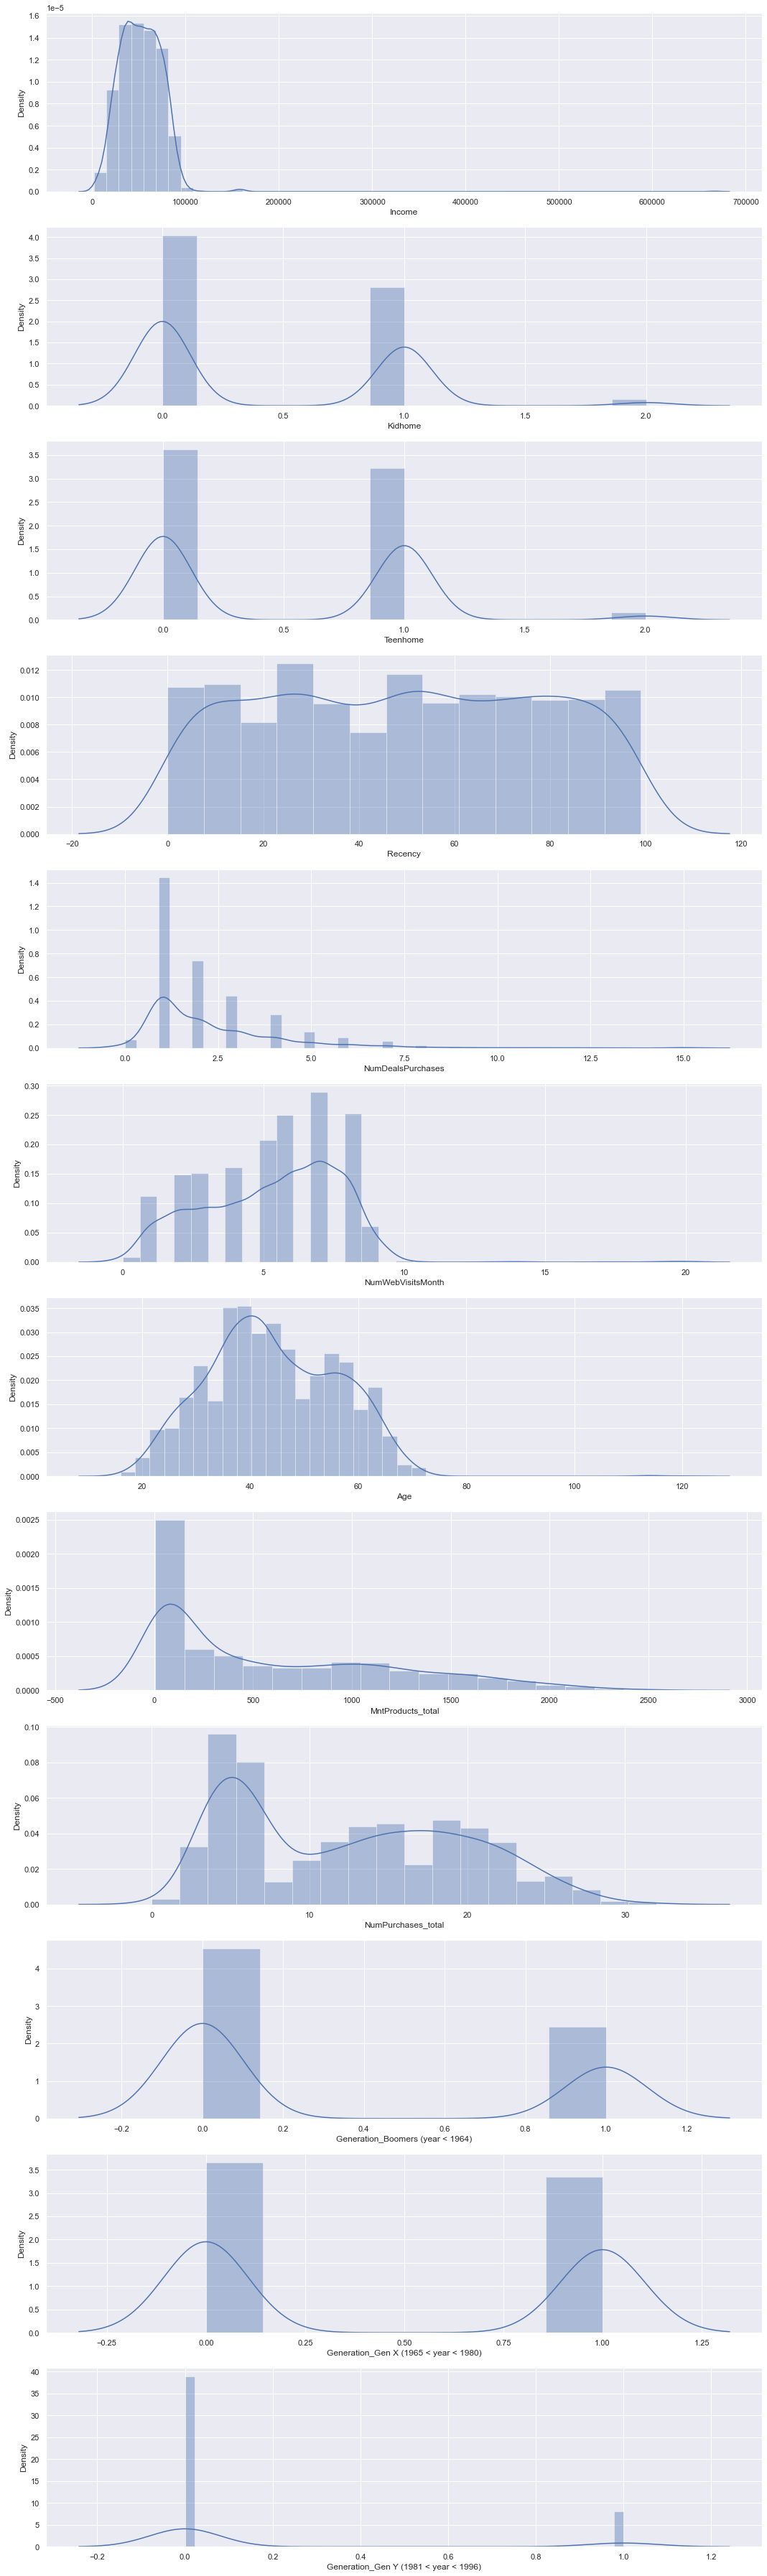

In [834]:
fig, ax = plt.subplots(25, figsize=(15,50))
sns.distplot(df_customers['Income'], ax=ax[0])
sns.distplot(df_customers['Kidhome'], ax=ax[1])
sns.distplot(df_customers['Teenhome'], ax=ax[2])
sns.distplot(df_customers['Recency'], ax=ax[3])
sns.distplot(df_customers['NumDealsPurchases'], ax=ax[4])
sns.distplot(df_customers['NumWebVisitsMonth'], ax=ax[5])
sns.distplot(df_customers['Age'], ax=ax[6])
sns.distplot(df_customers['MntProducts_total'], ax=ax[7])
sns.distplot(df_customers['NumPurchases_total'], ax=ax[8])
sns.distplot(df_customers['Education_2n Cycle'], ax=ax[9])
sns.distplot(df_customers['Education_Basic'], ax=ax[10])
sns.distplot(df_customers['Education_Graduation'], ax=ax[11])
sns.distplot(df_customers['Education_Master'], ax=ax[12])
sns.distplot(df_customers['Education_PhD'], ax=ax[13])
sns.distplot(df_customers['Marital_Status_Absurd'], ax=ax[14])
sns.distplot(df_customers['Marital_Status_Alone'], ax=ax[15])
sns.distplot(df_customers['Marital_Status_Divorced'], ax=ax[16])
sns.distplot(df_customers['Marital_Status_Married'], ax=ax[17])
sns.distplot(df_customers['Marital_Status_Single'], ax=ax[18])
sns.distplot(df_customers['Marital_Status_Together'], ax=ax[19])
sns.distplot(df_customers['Marital_Status_Widow'], ax=ax[20])
sns.distplot(df_customers['Marital_Status_YOLO'], ax=ax[21])
sns.distplot(df_customers['Generation_Boomers (year < 1964)'], ax=ax[22])
sns.distplot(df_customers['Generation_Gen X (1965 < year < 1980)'], ax=ax[23])
sns.distplot(df_customers['Generation_Gen Y (1981 < year < 1996)'], ax=ax[24])
plt.tight_layout()
plt.show()

In [763]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(df_customers[x], ax=ax[0,0])
    sns.distplot(np.log(df_customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(df_customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(df_customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(df_customers[x].skew().round(2))
    print(np.log(df_customers[x]).skew().round(2))
    print(np.sqrt(df_customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(df_customers[x])[0]).skew().round(2))

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

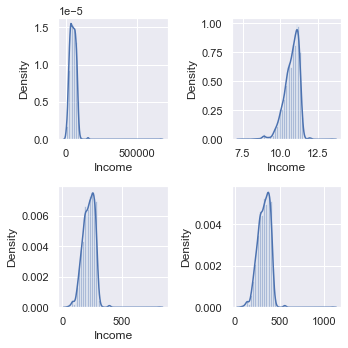

6.8
-1.18
0.39
0.23


In [1013]:
analyze_skewness('Income')

In [795]:
# Set the Numbers
customers_fix = pd.DataFrame()
customers_fix['Income'] = stats.boxcox(df_customers['Income'])[0]
customers_fix['Kidhome'] = stats.boxcox(df_customers['Kidhome'])[0]
customers_fix['Teenhome'] = stats.boxcox(df_customers['Teenhome'])[0]
customers_fix['Recency'] = df_customers['Recency']
customers_fix['NumDealsPurchases'] = stats.boxcox(df_customers['NumDealsPurchases'])[0]
customers_fix['NumWebVisitsMonth'] = df_customers['NumWebVisitsMonth']
customers_fix['Age'] = stats.boxcox(df_customers['Age'])[0]
customers_fix['MntProducts_total'] = stats.boxcox(df_customers['MntProducts_total'])[0]
customers_fix['NumPurchases_total'] = np.sqrt(df_customers['NumPurchases_total'])
customers_fix['Education_2n Cycle'] = df_customers['Education_2n Cycle']
customers_fix['Education_Basic'] = df_customers['Education_Basic']
customers_fix['Education_Graduation'] = df_customers['Education_Graduation']
customers_fix['Education_Master'] = df_customers['Education_Master']
customers_fix['Education_PhD'] = df_customers['Education_PhD']
customers_fix['Marital_Status_Absurd'] = df_customers['Marital_Status_Absurd']
customers_fix['Marital_Status_Alone'] = df_customers['Marital_Status_Alone']
customers_fix['Marital_Status_Divorced'] = df_customers['Marital_Status_Divorced']
customers_fix['Marital_Status_Married'] = df_customers['Marital_Status_Married']
customers_fix['Marital_Status_Single'] = df_customers['Marital_Status_Single']
customers_fix['Marital_Status_Together'] = df_customers['Marital_Status_Together']
customers_fix['Marital_Status_Widow'] = df_customers['Marital_Status_Widow']
customers_fix['Marital_Status_YOLO'] = df_customers['Marital_Status_YOLO']
customers_fix['Generation_Boomers (year < 1964)'] = df_customers['Generation_Boomers (year < 1964)']
customers_fix['Generation_Gen X (1965 < year < 1980)'] = df_customers['Generation_Gen X (1965 < year < 1980)']
customers_fix['Generation_Gen Y (1981 < year < 1996)'] = df_customers['Generation_Gen Y (1981 < year < 1996)']
customers_fix.tail()

,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebVisitsMonth,Age,MntProducts_total,NumPurchases_total,Education_2n Cycle,...,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Generation_Boomers (year < 1964),Generation_Gen X (1965 < year < 1980),Generation_Gen Y (1981 < year < 1996)
2235,359.064568,-42.016460,0.000000,46.0,0.779288,5.0,13.172259,14.718323,4.000000,1.000000e-11,...,1.000000e-11,1.000000e-11,1.000000e+00,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e+00,1.000000e-11
2236,366.627455,0.684314,0.000000,56.0,2.733800,7.0,16.778540,11.067307,3.872983,1.000000e-11,...,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e+00,1.000000e-11,1.000000e-11,1.000000e+00,1.000000e-11,1.000000e-11
2237,347.207458,-42.016460,-28.096213,91.0,0.000000,6.0,10.663302,14.438067,4.242641,1.000000e-11,...,1.000000e-11,1.000000e+00,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e+00
2238,380.340823,-42.016460,0.000000,8.0,0.779288,3.0,15.216566,13.096422,4.582576,1.000000e-11,...,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e+00,1.000000e-11,1.000000e-11,1.000000e+00,1.000000e-11,1.000000e-11
2239,335.253714,0.000000,0.000000,40.0,1.325440,7.0,15.216566,8.463239,2.828427,1.000000e-11,...,1.000000e-11,1.000000e-11,1.000000e+00,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e+00,1.000000e-11,1.000000e-11


After analysis, use of many variables increases dimensionality and harms the model.

For clustering these variables were used:
- Income
- MntProducts_total
- NumPurchases_total
- Recency

# Test using clustering algorithms

### K-Means

In [1233]:
kmeans_labels=KMeans(n_clusters=4,random_state=123).fit_predict(customers_normalized)

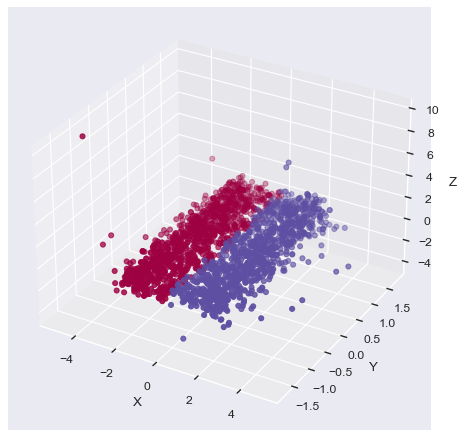

In [1203]:
pca = PCA(n_components=3).fit_transform(customers_normalized)
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=kmeans_labels,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

### MiniBatch K-Means

In [1215]:
minikm_labels = MiniBatchKMeans(n_clusters=4,init='random',batch_size=100000).fit_predict(customers_normalized)

### Hierarchical Clustering

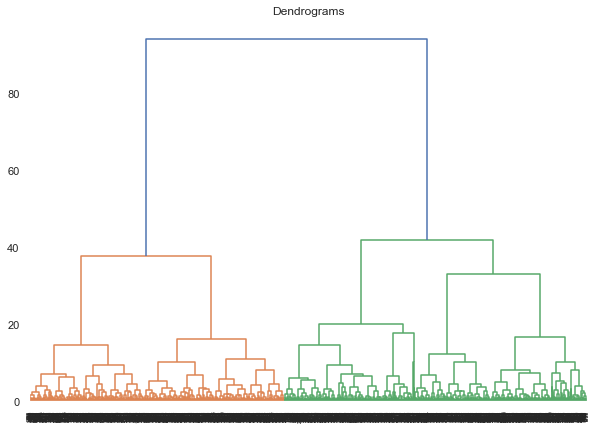

In [1145]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(customers_normalized, method='ward'))

In [1146]:
hcluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
hcp=hcluster.fit_predict(customers_normalized)
print('Silhouette Score for Hieararchial Clustering:'+str(metrics.silhouette_score(customers_normalized,hcp,metric='euclidean')))
print('Davies Bouldin Score:'+str(metrics.davies_bouldin_score(customers_normalized,hcp)))


Silhouette Score for Hieararchial Clustering:0.4239048892398938
Davies Bouldin Score:0.915091190107842


### DBSCAN Algorithm

In [1153]:
results=pd.DataFrame(columns=['Eps','Min_Samples','Number of Cluster','Silhouette Score'])
for i in range(1,12):
    for j in range(1,12):
        dbscan_cluster = DBSCAN(eps=i*0.2, min_samples=j)
        clusters=dbscan_cluster.fit_predict(customers_normalized)
        if len(np.unique(clusters))>2:
            results=results.append({'Eps':i*0.2,
                                    'Min_Samples':j,
                                    'Number of Cluster':len(np.unique(clusters)),
                                    'Silhouette Score':metrics.silhouette_score(customers_normalized,clusters),
                                    'Davies Bouldin Score':metrics.davies_bouldin_score(customers_normalized,clusters)}, ignore_index=True)

In [1154]:
results.sort_values('Silhouette Score',ascending=False)[:5]

,Eps,Min_Samples,Number of Cluster,Silhouette Score,Davies Bouldin Score
33,2.0,2.0,4.0,0.436987,3.434467
31,1.8,2.0,4.0,0.435941,5.680690
29,1.6,2.0,4.0,0.435775,3.589418
35,2.2,2.0,5.0,0.390963,0.508751
34,2.2,1.0,5.0,0.390963,0.508751


In [1173]:
dbscan_cluster = DBSCAN(eps=2.2, min_samples=2)
db_clusters=dbscan_cluster.fit_predict(customers_normalized)

### GMM Algorithm

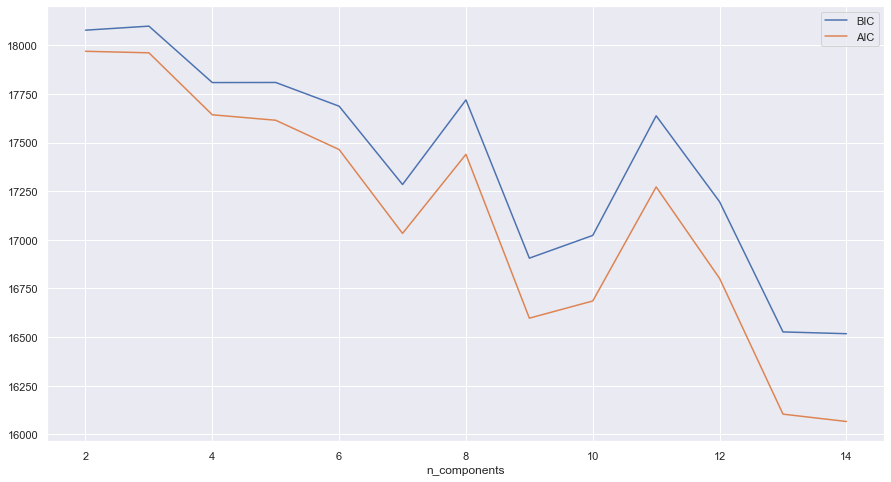

In [1179]:
models = [GaussianMixture(n,covariance_type='tied', random_state=123).fit(customers_normalized) for n in range(2,15)]
plt.plot(range(2,15), [m.bic(customers_normalized) for m in models], label='BIC')
plt.plot(range(2,15), [m.aic(customers_normalized) for m in models], label='AIC')
plt.legend()
plt.xlabel('n_components')
plt.show()

In [1180]:
parameters=['full','tied','diag','spherical']
n_clusters=np.arange(1,21)
results_=pd.DataFrame(columns=['Covariance Type','Number of Cluster','Silhouette Score','Davies Bouldin Score'])
for i in parameters:
    for j in n_clusters:
        gmm_cluster=GaussianMixture(n_components=j,covariance_type=i,random_state=123)
        clusters=gmm_cluster.fit_predict(customers_normalized)
        if len(np.unique(clusters))>=2:
            results_=results_.append({"Covariance Type":i,'Number of Cluster':j,"Silhouette Score":metrics.silhouette_score(customers_normalized,clusters),
                                      'Davies Bouldin Score':metrics.davies_bouldin_score(customers_normalized,clusters)},
                                     ignore_index=True)


In [1181]:
display(results_.sort_values(by=["Silhouette Score"], ascending=False)[:5])

,Covariance Type,Number of Cluster,Silhouette Score,Davies Bouldin Score
57,spherical,2,0.456215,0.872756
38,diag,2,0.455639,0.876145
19,tied,2,0.452969,0.876148
0,full,2,0.433617,0.909896
1,full,3,0.423082,5.344465


In [1194]:
gmm_cluster=GaussianMixture(n_components=2,covariance_type="spherical",random_state=123)
gmm_cluster.fit(customers_normalized)
gmm_labels = gmm_cluster.predict(customers_normalized)

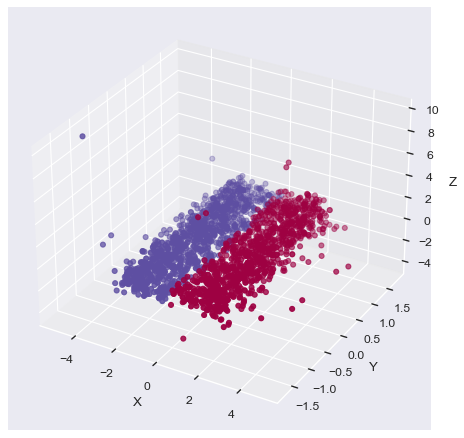

In [1218]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=gmm_labels,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

### MeanShift

In [1197]:
est_bandwidth = estimate_bandwidth(customers_normalized,quantile=0.1,n_samples=10000)
mean_shift = MeanShift(bandwidth= est_bandwidth, bin_seeding=True).fit(customers_normalized)
labels_unique=np.unique(mean_shift.labels_)
n_clusters_=len(labels_unique)
print("Number of estimated clusters : %d" % n_clusters_)

Number of estimated clusters : 16


### Comparison of Results

In [1216]:
algorithms=["K-Means","MiniBatch K-Means","Hierarchical Clustering","DBSCAN","Gaussian Mixture Model","MeanShift"]

# Silhouette Score
ss=[metrics.silhouette_score(customers_normalized,kmeans_labels),metrics.silhouette_score(customers_normalized,minikm_labels),metrics.silhouette_score(customers_normalized,hcp),
   metrics.silhouette_score(customers_normalized,db_clusters),metrics.silhouette_score(customers_normalized,gmm_labels),metrics.silhouette_score(customers_normalized,mean_shift.labels_)]

# Davies Bouldin Score
db=[metrics.davies_bouldin_score(customers_normalized,kmeans_labels),metrics.davies_bouldin_score(customers_normalized,minikm_labels),metrics.davies_bouldin_score(customers_normalized,hcp),
   metrics.davies_bouldin_score(customers_normalized,db_clusters),metrics.davies_bouldin_score(customers_normalized,gmm_labels),metrics.davies_bouldin_score(customers_normalized,mean_shift.labels_)]


In [1217]:
comprsn={"Algorithms":algorithms,"Davies Bouldin":db,"Silhouette Score":ss}
compdf=pd.DataFrame(comprsn)
display(compdf.sort_values(by=["Silhouette Score"], ascending=False))

,Algorithms,Davies Bouldin,Silhouette Score
4,Gaussian Mixture Model,0.872756,0.456215
2,Hierarchical Clustering,0.915091,0.423905
3,DBSCAN,0.508751,0.390963
0,K-Means,1.111920,0.340145
1,MiniBatch K-Means,1.114144,0.338867
5,MeanShift,0.605757,0.272765


In [1234]:
customers_fix['Clusters']=list(kmeans_labels)
customers_1=pd.DataFrame(customers_fix['Clusters'].value_counts()).rename(columns={'Clusters':'Number of Customers'})
customers_1.T

,3,1,0,2
Number of Customers,616,580,524,520


In [1235]:
customers_fix.set_index('Clusters')
grouped=customers_fix.groupby(by='Clusters').mean().round(1)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/lib/python

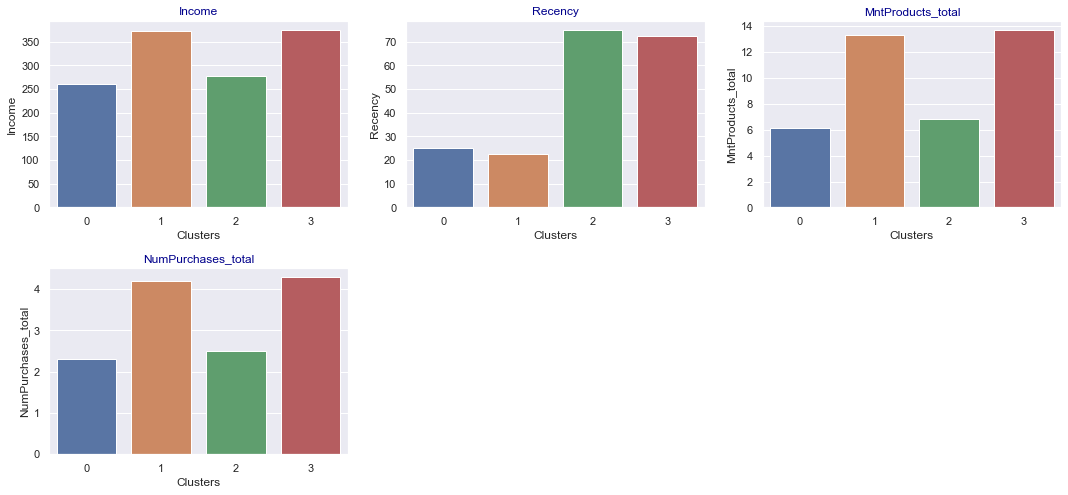

In [1236]:
features=["Income","Recency","MntProducts_total","NumPurchases_total"]
plt.figure(figsize=(15,10))
for i,j in enumerate(features):
    plt.subplot(3,3,i+1)
    sns.barplot(grouped.index,grouped[j])
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()

### References

https://github.com/muhammetbektas/Unsupervised-Learning/blob/master/Segmentation_of_Credit_Card_Users.ipynb